# Setting Up Environment

In [145]:
import re
import nltk
import spacy
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

In [146]:
import csv
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Get Master Dataframe with All Topics
We parse through each CSV topic article and then read them into a master dataframe consisting a datetime, news type, and text column. Each article row pertains to a paragraph!

In [161]:
def get_master_df():
    numbers = ["1","2","3","4","5","6","7","8","9","10"]
    letters = ["B"]
    df_list = list()
    path = "2_csv_text/"
    for letter in letters:
        for num in numbers:
            file = letter + num
            df = pd.read_csv(path+file+".csv",header=None)
            df.drop(df.columns[0], axis=1,inplace=True)
            df_list.append(df)
    df = pd.concat(df_list,ignore_index=True)
    df.columns = ["date","news","text"]
    df["date"] = pd.to_datetime(df["date"], format='%m-%d-%Y')
    count = df['text'].str.split().str.len()
    return df[~(count < 4)]

# Stop Word Removal & Clean Up

In [162]:
# Stop Words Removal & Lemmatizing
spacy_nlp = spacy.load('en_core_web_sm')

remove_stops = spacy.lang.en.stop_words.STOP_WORDS
nltk_stops   = stopwords.words('english')
custom_stops = [".com","say","year","a","b","c","d","e","f","g","h","i","j",
                "k","l","m","n","o","p","q","r","s","t","u","v","w","x","y","z"]

for word in nltk_stops:
    spacy_nlp.vocab[word].is_stop = True
    
def tokenize_removestops(text):
    tokens = [token.text for token in spacy_nlp(text) if not token.is_stop]
    no_spaces = list(filter(lambda word: re.sub(r'[\W_]+','', word), tokens))
    processed = list(filter(lambda word: word not in custom_stops, no_spaces))
    return processed

# Pre-Processing of Text

In [163]:
def generate_tokens(sentence_list):
    final_tokens = []
    for sentence in sentence_list:
        new_text = re.sub("'|\.|\s+|\d+|[^a-zA-Z0-9]"," ", str(sentence).lower())
        tokens = tokenize_removestops(new_text.lower())
        if len(tokens) >= 3:
            final_tokens.append(tokens)
    return final_tokens

In [164]:
df = get_master_df()
df = df.groupby(["news","date"]).text.agg(sum).reset_index()

df["sentences"] = df.text.apply(lambda x: str(x).split("."))
df["clean_tokens"] = df.sentences.apply(generate_tokens)
df.dropna(inplace=True)

pd.options.display.max_colwidth = 150
df.head()

,news,date,text,sentences,clean_tokens
0,Business,2018-06-04,Sharp to buy Toshiba PC business issue $1.8 billion in new sharesTOKYO (Reuters) - Japan’s Sharp Corp (6753.T) said it will buy Toshiba Corp’s (65...,"[Sharp to buy Toshiba PC business issue $1, 8 billion in new sharesTOKYO (Reuters) - Japan’s Sharp Corp (6753, T) said it will buy Toshiba Corp’s ...","[[sharp, buy, toshiba, pc, business, issue], [billion, new, sharestokyo, reuters, japan, sharp, corp], [said, buy, toshiba, corp], [personal, comp..."
1,Business,2018-07-02,4 Stocks With Bounce-Back Potential: Thor Industries Lam Research & MoreI love buying stocks when they’re down.That’s the point of my quarterly Ca...,"[4 Stocks With Bounce-Back Potential: Thor Industries Lam Research & MoreI love buying stocks when they’re down, That’s the point of my quarterly ...","[[stocks, bounce, potential, thor, industries, lam, research, morei, love, buying, stocks], [point, quarterly, casualty, list], [start, new, quart..."
2,Business,2018-08-13,U.S. stocks close lower as Turkey currency crisis dampens risk appetiteTurkey rattles U.S. markets again.U.S. stocks closed lower Monday with the ...,"[U, S, stocks close lower as Turkey currency crisis dampens risk appetiteTurkey rattles U, S, markets again, U, S, stocks closed lower Monday w...","[[stocks, close, lower, turkey, currency, crisis, dampens, risk, appetiteturkey, rattles], [stocks, closed, lower, monday, dow, jones, industrial,..."
3,Business,2018-09-20,Record highs — What you need to know in markets on FridayStocks are at record highs.After 164 sessions without a record close the Dow Jones Indust...,"[Record highs — What you need to know in markets on FridayStocks are at record highs, After 164 sessions without a record close the Dow Jones Indu...","[[record, highs, need, know, markets, fridaystocks, record, highs], [sessions, record, close, dow, jones, industrial, average, thursday, closed, r..."
4,Business,2018-10-28,Alexa for Business opens up to third-party device makersLast year Amazon announced a new initiative Alexa for Business designed to introduce its v...,[Alexa for Business opens up to third-party device makersLast year Amazon announced a new initiative Alexa for Business designed to introduce its ...,"[[alexa, business, opens, party, device, makerslast, amazon, announced, new, initiative, alexa, business, designed, introduce, voice, assistant, t..."


# Word2Vec with Window Size of 5
300 dimensional word embeddings

In [165]:
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

model = Word2Vec(df["clean_tokens"].sum(), size=300, sg=1, window=5, min_count=3, seed=123)

print(model)

Word2Vec(vocab=392, size=300, alpha=0.025)


In [166]:
# Get list of words for annotation of the scatter plot
vocab = list(model.wv.vocab)
X = model[vocab]

# Project them onto the 2 Dimensional space
tsne = TSNE(n_components=2,random_state=123)
X_tsne = tsne.fit_transform(X)

# Create a DataFrame with words as index and 2 dimensions as main columns (x-axis, y-axis)
scatter_df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

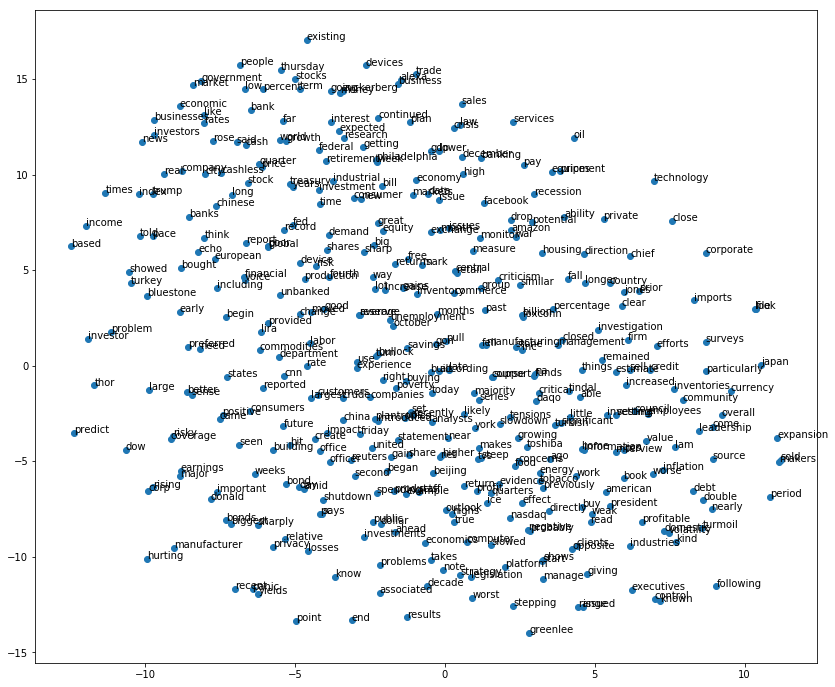

In [167]:
# Plot the figure
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(scatter_df['x'], scatter_df['y'])

# Annotate each point with its word
for word, pos in scatter_df.iterrows():
    ax.annotate(word, pos)
    
plt.show()

In [168]:
model.wv.most_similar(positive=["computer"],topn=10)

[('slowed', 0.19103215634822845),
 ('measure', 0.17082475125789642),
 ('cnn', 0.16486498713493347),
 ('analysts', 0.16048702597618103),
 ('set', 0.1425493061542511),
 ('example', 0.14100560545921326),
 ('think', 0.1392427384853363),
 ('directly', 0.13096827268600464),
 ('staff', 0.12698811292648315),
 ('worse', 0.11456257849931717)]

In [169]:
model.wv.most_similar(positive=["war"],topn=10)

[('market', 0.4652712345123291),
 ('percent', 0.42921414971351624),
 ('term', 0.42294400930404663),
 ('government', 0.39907127618789673),
 ('like', 0.39339619874954224),
 ('economic', 0.3785248398780823),
 ('told', 0.37261301279067993),
 ('amazon', 0.3717562258243561),
 ('existing', 0.3661595284938812),
 ('quarter', 0.36553987860679626)]

In [170]:
model.wv.most_similar(positive=["facebook"],topn=10)

[('government', 0.49341660737991333),
 ('people', 0.481284499168396),
 ('market', 0.4791174829006195),
 ('term', 0.47022709250450134),
 ('long', 0.45751044154167175),
 ('like', 0.44955703616142273),
 ('stocks', 0.44688522815704346),
 ('thursday', 0.44128358364105225),
 ('business', 0.4379819333553314),
 ('lower', 0.4308564364910126)]

In [171]:
print(model.wv.most_similar(positive=["analysts","investor"], negative=["market"], topn=2))

[('savings', 0.17428313195705414), ('source', 0.10440261662006378)]


In [172]:
print(model.wv.most_similar(positive=["interest","bonds"], negative=["stocks"], topn=3))

[('continued', 0.31210964918136597), ('investment', 0.30423927307128906), ('biggest', 0.2973318099975586)]


In [173]:
print(model.wv.most_similar(positive=["donald","trump"], topn=2))

[('government', 0.4335134029388428), ('businesses', 0.4172137975692749)]


In [174]:
print(model.wv.most_similar(positive=["legislation","american"], topn=4))

[('going', 0.36799463629722595), ('rates', 0.35892853140830994), ('quarter', 0.35082608461380005), ('need', 0.33690062165260315)]


In [175]:
print(model.wv.most_similar(positive=["zuckerberg","stocks"], topn=4))

[('term', 0.633190393447876), ('money', 0.5963645577430725), ('interest', 0.5909152626991272), ('market', 0.5848158597946167)]


In [176]:
print(model.wv.most_similar(positive=["oil","inventory"], topn=2))

[('money', 0.4915943443775177), ('people', 0.4769548177719116)]


In [177]:
print(model.wv.most_similar(positive=["devices","technology"], negative=["stocks"], topn=5))

[('existing', 0.23767238855361938), ('staff', 0.21691012382507324), ('zuckerberg', 0.2159695327281952), ('alexa', 0.2151208221912384), ('provided', 0.21035367250442505)]


In [178]:
print(model.wv.most_similar(positive=["dow","jones"], topn=5))

[('treasury', 0.4103504717350006), ('people', 0.36952513456344604), ('interest', 0.3596799075603485), ('market', 0.3574627637863159), ('business', 0.35138916969299316)]


In [179]:
print(model.wv.most_similar(positive=["gdp","economy"], topn=5))

[('market', 0.6121593713760376), ('stocks', 0.5862126350402832), ('term', 0.5563004612922668), ('like', 0.5548907518386841), ('interest', 0.5440171957015991)]


In [180]:
print(model.wv.most_similar(positive=["privacy","problems"],negative=["market"], topn=4))

[('associated', 0.07699616253376007), ('day', 0.062468867748975754), ('computer', 0.0612243190407753), ('hurting', 0.05847734212875366)]


# Word2Vec with Window Size of 10
300 dimensional word embeddings

In [181]:
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

model = Word2Vec(df["clean_tokens"].sum(), size=300, sg=1, window=10, min_count=3, seed=1)

print(model)

Word2Vec(vocab=392, size=300, alpha=0.025)


In [182]:
# Get list of words for annotation of the scatter plot
vocab = list(model.wv.vocab)
X = model[vocab]

# Project them onto the 2 Dimensional space
tsne = TSNE(n_components=2,random_state=1)
X_tsne = tsne.fit_transform(X)

# Create a DataFrame with words as index and 2 dimensions as main columns (x-axis, y-axis)
scatter_df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

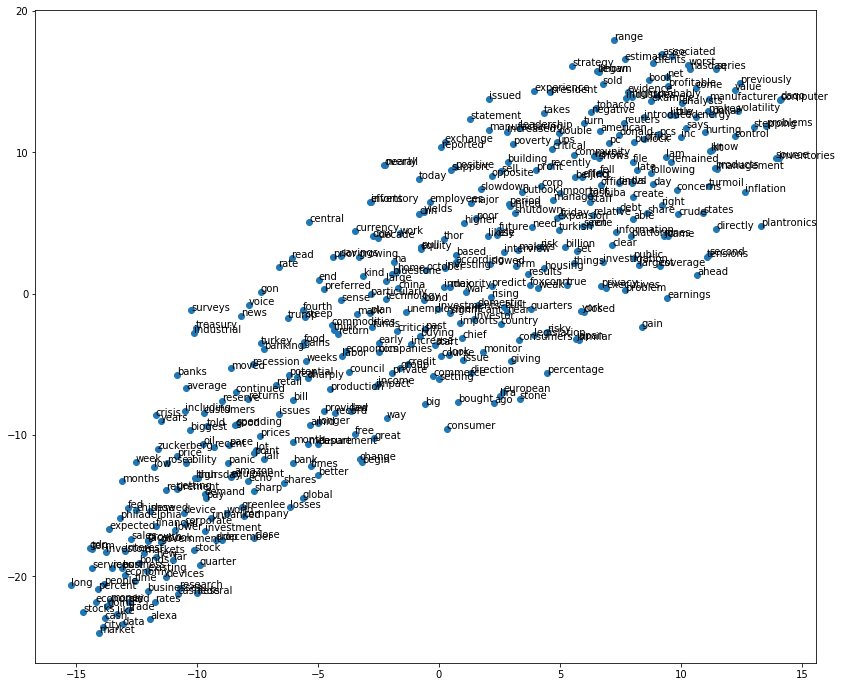

In [183]:
# Plot the figure
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(scatter_df['x'], scatter_df['y'])

# Annotate each point with its word
for word, pos in scatter_df.iterrows():
    ax.annotate(word, pos)
    
plt.show()

In [184]:
model.wv.most_similar(positive=["computer"],topn=10)

[('problems', 0.15980137884616852),
 ('recently', 0.14640238881111145),
 ('treasury', 0.14211420714855194),
 ('daqo', 0.13889500498771667),
 ('building', 0.13340261578559875),
 ('unemployment', 0.12657064199447632),
 ('fourth', 0.1261099874973297),
 ('company', 0.11997942626476288),
 ('important', 0.11415857821702957),
 ('slowdown', 0.1102391704916954)]

In [185]:
model.wv.most_similar(positive=["war"],topn=10)

[('city', 0.7087075710296631),
 ('data', 0.7029075622558594),
 ('new', 0.6955171823501587),
 ('economy', 0.6953791379928589),
 ('going', 0.6933993697166443),
 ('far', 0.6926276683807373),
 ('economic', 0.6922622919082642),
 ('lower', 0.6871247887611389),
 ('cash', 0.6870585680007935),
 ('market', 0.6835224628448486)]

In [186]:
model.wv.most_similar(positive=["facebook"],topn=10)

[('said', 0.848118782043457),
 ('cash', 0.8367924690246582),
 ('trade', 0.8361796140670776),
 ('market', 0.8320250511169434),
 ('stocks', 0.8296152353286743),
 ('city', 0.8266265392303467),
 ('alexa', 0.826267659664154),
 ('time', 0.8260491490364075),
 ('money', 0.8238587379455566),
 ('business', 0.8214989900588989)]

In [187]:
print(model.wv.most_similar(positive=["analysts","investor"], negative=["market"], topn=5))

[('change', 0.18723735213279724), ('rising', 0.17341852188110352), ('evidence', 0.15520283579826355), ('setting', 0.14325203001499176), ('domestic', 0.13980978727340698)]


In [188]:
print(model.wv.most_similar(positive=["interest","bonds"], negative=["stocks"], topn=3))

[('market', 0.7553178071975708), ('going', 0.7515588998794556), ('like', 0.7429361343383789)]


In [189]:
print(model.wv.most_similar(positive=["donald","trump"], topn=3))

[('trade', 0.7361307144165039), ('market', 0.7355953454971313), ('report', 0.7224865555763245)]


In [190]:
print(model.wv.most_similar(positive=["legislation","american"], negative=["market"], topn=4))

[('return', 0.2812790870666504), ('potential', 0.2806316614151001), ('donald', 0.2785678505897522), ('risky', 0.27498817443847656)]


In [191]:
print(model.wv.most_similar(positive=["zuckerberg","stocks"], negative=["market"], topn=4))

[('rates', 0.7046475410461426), ('said', 0.7016119360923767), ('cash', 0.7002536654472351), ('gdp', 0.6995929479598999)]


In [192]:
print(model.wv.most_similar(positive=["oil","inventory"], negative=["market"], topn=3))

[('long', 0.4687868356704712), ('research', 0.46835702657699585), ('interest', 0.4649679958820343)]


In [193]:
print(model.wv.most_similar(positive=["devices","technology"], negative=["stocks"], topn=5))

[('market', 0.6350865364074707), ('alexa', 0.6274809837341309), ('corporate', 0.6222401261329651), ('money', 0.614915668964386), ('like', 0.614204466342926)]


In [194]:
print(model.wv.most_similar(positive=["dow","jones"], topn=5))

[('city', 0.6941426992416382), ('economic', 0.6938381195068359), ('economy', 0.6908421516418457), ('market', 0.687342643737793), ('people', 0.6843339204788208)]


In [195]:
print(model.wv.most_similar(positive=["gdp","economy"], topn=5))

[('market', 0.8958903551101685), ('city', 0.8958687782287598), ('trade', 0.8951538801193237), ('going', 0.8946099281311035), ('said', 0.883965015411377)]


In [196]:
print(model.wv.most_similar(positive=["privacy","problems"],negative=["market"], topn=4))

[('control', 0.17450252175331116), ('tensions', 0.16042041778564453), ('donald', 0.15823917090892792), ('sense', 0.13482613861560822)]
